# TP1

Thomas Vaudescal : **11237578**
William Delisle : **11313171**
Sébastien Caron : **11271997**

# Question 1

Une action ne versant pas de dividende cote présentement à 100. Le taux sans risque à 1 mois est de 5%. Vous observez sur le marché les prix suivants pour des puts européens venant à maturité dans 1 mois:

In [1]:
from utils import *

tic()

# use 4 decimals for tables
pd.options.display.float_format = "{:,.4f}".format

In [2]:
info = get_info()
info

,Strike,Put
0,80.0000,0.1900
1,90.0000,0.6907
2,97.5000,1.6529
3,102.5000,3.3409
4,110.0000,9.8399
5,120.0000,19.5805


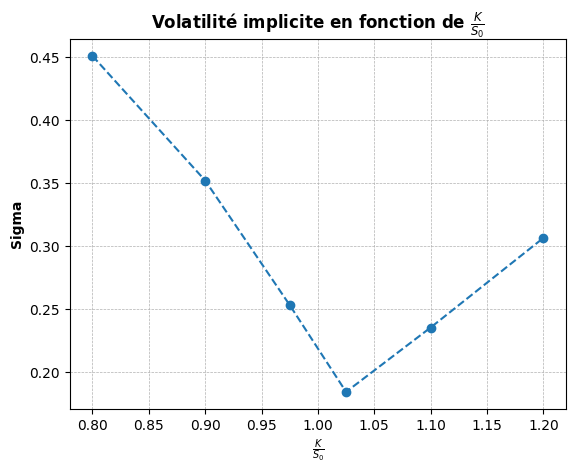

In [3]:
# Données
S_0 = 100.0
r_f = 0.05
T = 1.0 / 12.0

# Calcul des volatilités implicites
sigma = [
    implied_volatility(opt_price=P, S=S_0, K=K, r=r_f, y=0, T=T, is_call=False)[0]
    for K, P in info.values
]
info["Implied vol."] = sigma

plot_implied_vol(S_0, info)

Quelles sont les volatilités implicites ('IV') de ces puts? Tracez le graphe des ces IV en fonction de $K/S$ et discutez brièvement.

Selon la théorie du Modèle de Black-Scholes, la volatilité implicite est supposée constante pour différents prix strikes $K$. Cependant et sur notre graphique, nous observons que la volatilité implicite tend à former un "smile" en fonction de la "moneyness". En effet, nous observons que la volatilité implicite est supérieure lorsque l'option est dans la monnaie ($S0 < K$ ou encore $\frac{K}{S_0} > 1$) ou hors de la monnaie ($S0 > K$ ou encore $\frac{K}{S_0} < 1$). On observe aussi que la volatilité implicite tend à être la plus faible quand l'option est à la monnaie ($IV = 0.1845$ pour $K = 102.5$). Ce phénomène est dû au fait que le modèle de Black Schole ne prend pas en compte tous les facteurs qui affectent la volatilité implicite des options, comme par exemple la **liquidité, l'offre et la demande.**

# Question 2

Vous vous intéressez à ces options parce que vous avez, d'autre part, 
émis des produits structurés contenant des puts de même strikes, mais permettant un exercice à tout moment d'ici la maturité. Pour chacun de ces strike, vous désirez donc utiliser un arbre CRR afin de valoriser l'option américaine correspondante.

En premier lieu, vous désirez donc étudier la convergence de votre arbre vers le prix BMS pour les européennes observées sur le marché. Pour des valeurs de $N$ allant de 2 à 100 (`range(2,101)`), tracer, dans une figure 
`
    fig, axes = plt.subplots(3, 2, figsize=(15,20))
`
avec une sous-figure par strike,

* Le prix CRR obtenu pour chaque $N$
* Une ligne horizontale traitillée au prix de marché
* Deux ligne horizontales pointillées à $\pm$1 bp du prix de marché

Discutez brièvement de la qualité de la convergence.

In [4]:
N_Range = np.arange(2, 101, 1)
df_CRR = CRR_tree_df(
    S=S_0,
    K=info["Strike"],
    T=T,
    r=r_f,
    sigma=info["Implied vol."],
    Type=0,
    N_Range=N_Range,
)



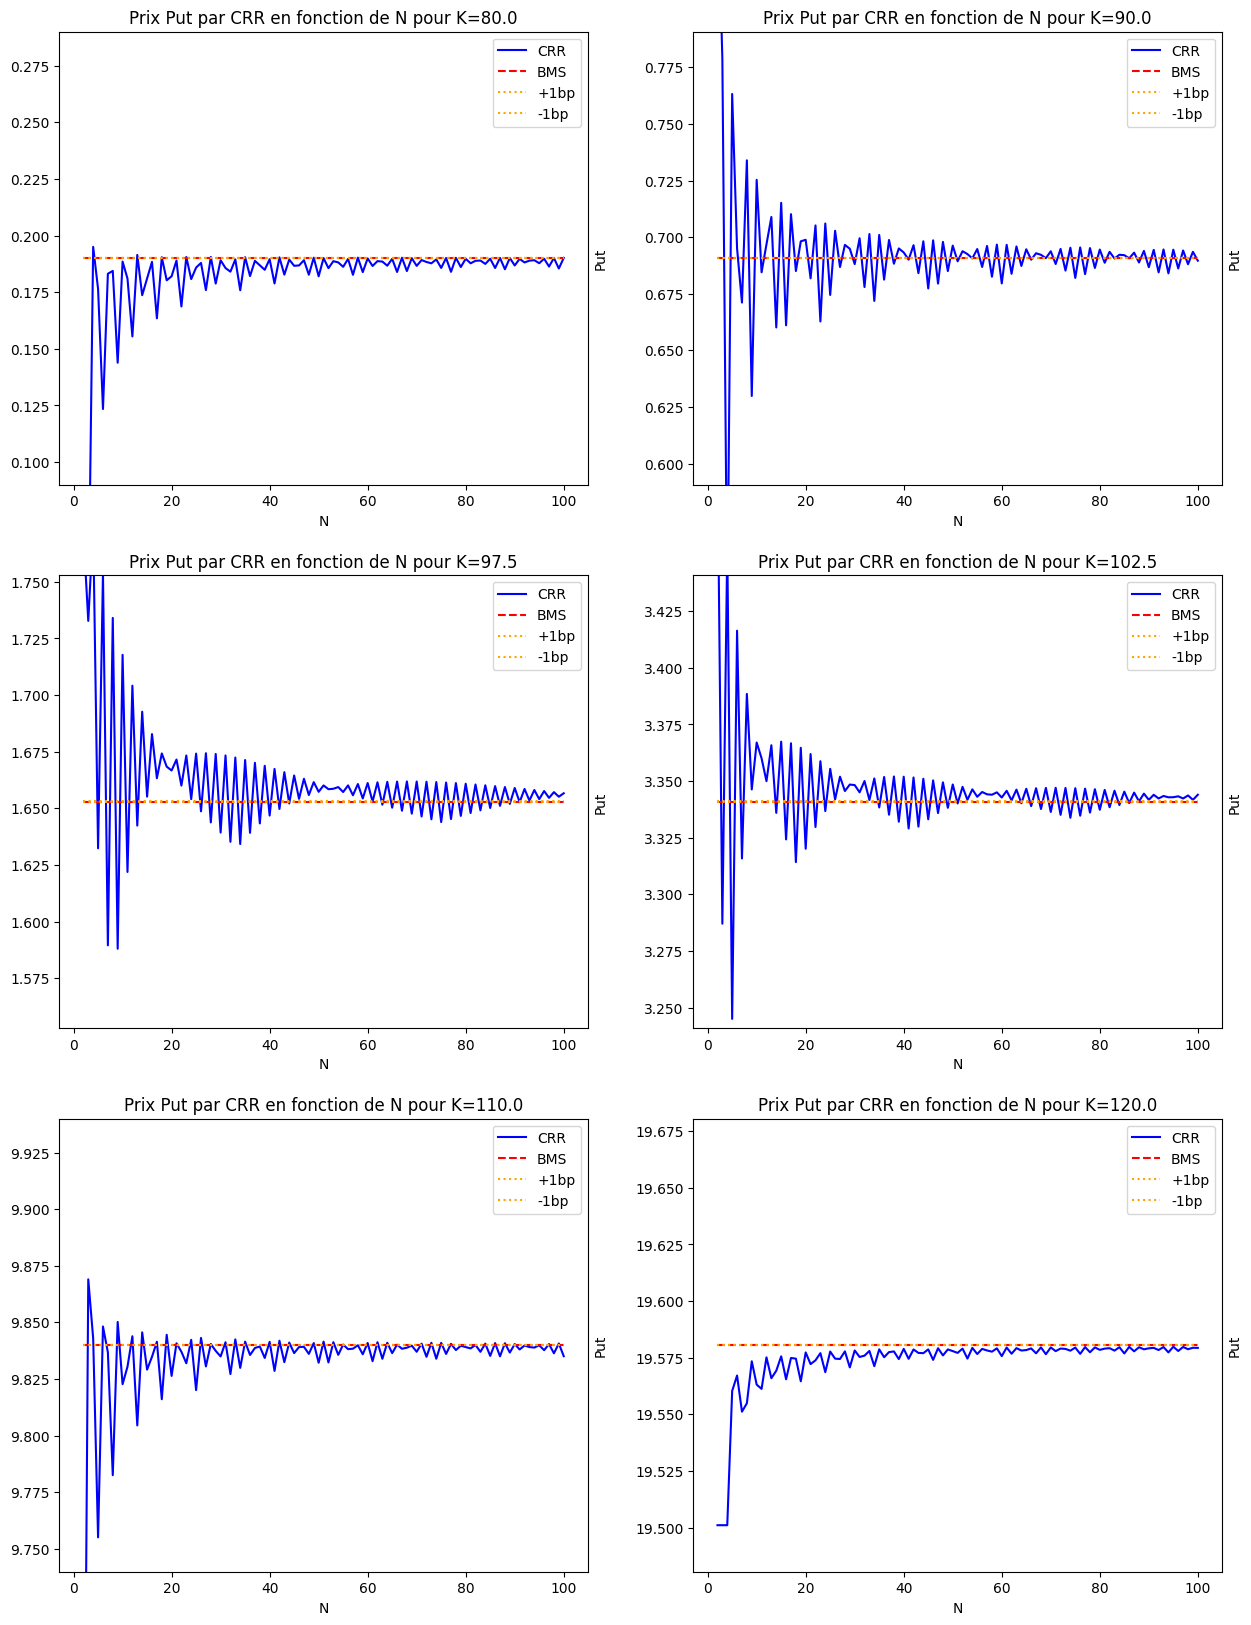

In [5]:
plot_CRR_tree(df_CRR_list=[[df_CRR, "CRR", "b"]], N_Range=N_Range, zoom_factor=1000)

À première vue, on remarque que après 100 pas de temps, l'arbre binomial CRR peine à converger vers la valeur théorique du put selon BMS. De plus, on remarque que pour de petites valeurs de `N`, l'erreur est très importante. Au fur et à mesure que N augmente, on observe que l'arbre binomial à l'air de converger lentement mais toujours avec beaucoup de variabilité dans les estimations. On remarque aussi que les oscillations dépendent de si le nombre de pas de temps `N` est pair ou impair. On sait que l'espérance de log-rendement de l'arbre binomial $\mathbb{E}\left[ln\left(\frac{S(t_n)}{S}\right)\right]$ est équivalente à l'espérance de log-rendement dans le modèle de BMS. On sait aussi que la variance de l'arbre binomial de CRR tend asympotiquement vers la variance du modèle de BMS en fonction du nombre de pas de temps. Cela expliquerait donc pourquoi la variance de l'arbre CRR à l'air de lentement diminuer en fonction du pas de temps `N` sur nos graphiques.

# Question 3

Répétez la figure ci-haut, en vous concentrant sur les pas $N = range(400, 501)$. 
Ajoutez aussi, pour chaque strike, une courbe raportant la valeur obtenu à $N$ avec l'arbre CRR ajusté à l'aide de la correction de Broadie et Detemple. Comparez les deux méthodes. En particulier, soulignez l'avantage de l'ajustement quand viendra le temps de choisir un nombre de pas de temps respectant une tolérance de $\pm$ 1bp.

In [6]:
N_Range = np.arange(400, 501)
df_CRR = CRR_tree_df(
    S=S_0,
    K=info["Strike"],
    T=T,
    r=r_f,
    sigma=info["Implied vol."],
    Type=0,
    N_Range=N_Range,
)
df_CRR_BD = CRR_tree_BD_df(
    S=S_0,
    K=info["Strike"],
    T=T,
    r=r_f,
    sigma=info["Implied vol."],
    Type=0,
    N_Range=N_Range,
)

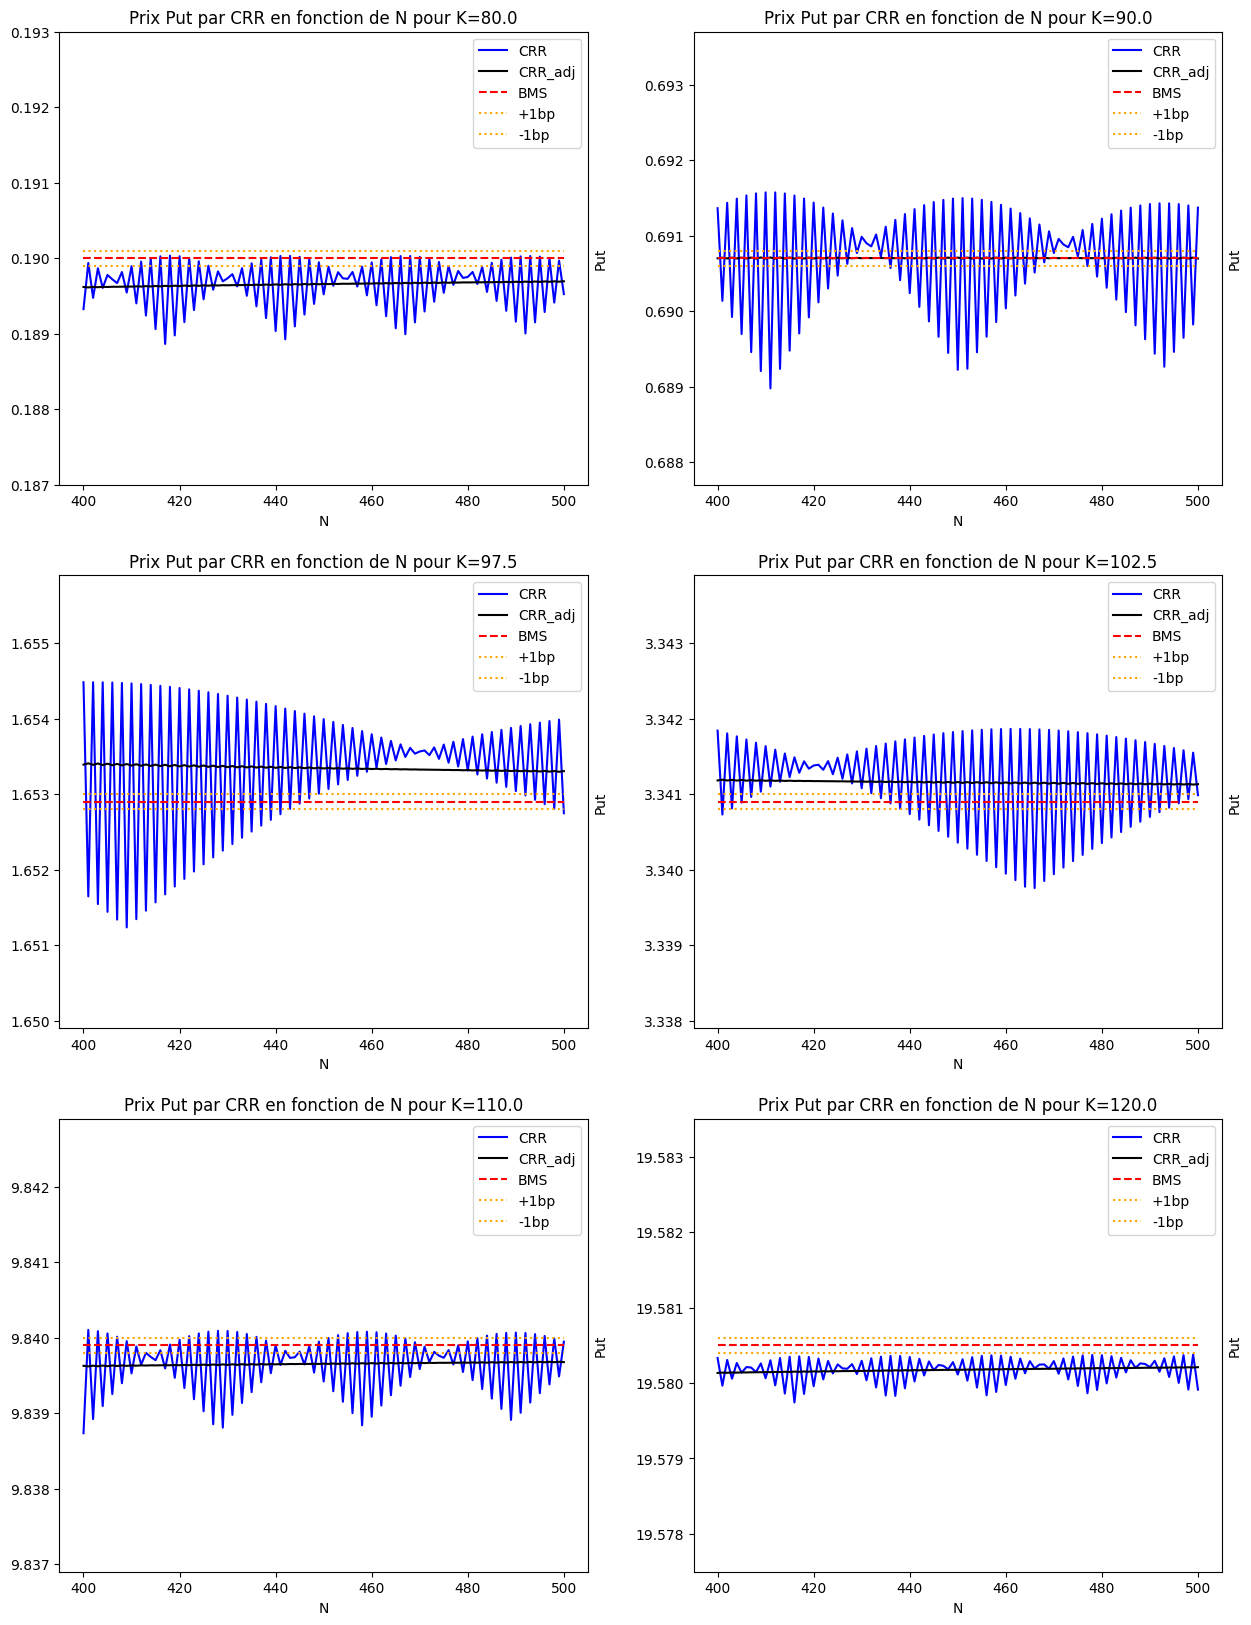

In [7]:
plot_CRR_tree(
    df_CRR_list=[[df_CRR, "CRR", "b"], [df_CRR_BD, "CRR_adj", "k"]],
    N_Range=N_Range,
    zoom_factor=30,
)

On remarque que même avec plus de pas de temps, la méthode CRR classique semble converger de façon oscillatoire vers le prix BMS. Par contre, lorsque la correction de Broadie et Detemple est applliquée, la convergence devient beaucoup plus lisse. L'avantage de ce comportement plus linéaire de la convergence avec l'arbre CRR ajusté est que, une fois la borne acceptable de convergence atteinte, l'arbre ajusté ne donnera plus de prix qui sorte de cette borne. Il sera donc beaucoup plus facile de choisir un nombre de pas de temps qui repecte une tolérance puisqu'il suffira d'identifier le point où cette tolérance est atteinte. Cette technique d'identification ne fonctionnerait pas avec une covergence oscillatoire puisqu'une fois à l'intérieur de la tolérance, il serait possbile d'en ressortir.

Finalement, il est intéressant de noter que, même si la correction de Broadie et Detemple a été developpée afin d'améliorer la convergence de l'arbre CRR lors de la tarification d'options américaines, la technique fonctionne aussi pour nos puts européens. C'est logique puisque l'idée de Broadie et Detemple était d'exploiter le caractère européen du dernier pas de temps dans l'arbre binomiale pour une option américaine. Or, pour une option européenne, le caractère du dernier pas de temps est évidemment aussi européen. 

# Question 4

En utilisant maintenant que les pas $N = range(500, 3001, 100)$, n'utilisez que l'arbre avec ajustement. Tracez à nouveau une figure de convergence 3x2. Combien de pas de temps sont nécessaires pour que tous les strikes respectent une tolérance de $\pm$ 1bp?

Assurez-vous aussi, pour chaque $N$, de calculer les 3 approximations suivantes du gamma:
\begin{align}
 \Gamma_0 &= \frac{p_{uu}-2p_{ud}+p_{dd}}{\left[(u-d) S\right]^{2}},
 \\
 \Gamma_1 &= \frac{
    \frac{(p_{uu}-p_{ud})}{u^{2}S-S} 
    - \frac{(p_{ud}-p_{dd})}{S-d^{2}S}
  }{Su - Sd},
 \\
 \Gamma_2 &= \frac{
    \frac{(p_{uu}-p_{ud})}{u^{2}S-S} 
    - \frac{(p_{ud}-p_{dd})}{S-d^{2}S}
  }{\frac{1}{2}(Su^2 - Sd^2)}.
\end{align}

Produisez une nouvelle figure de convergence, cette fois vers $\Gamma_{BMS}\pm 1bp$. Discutez brièvement.

In [8]:
N_Range = np.arange(500, 3001, 100)

gamma_bms = [gamma(S=S_0, K=K, r=r_f, y=0, T=T, sigma=Sig) for K, _, Sig in info.values]
df_CRR_BD, gamma_BD = CRR_tree_BD_df(
    S=S_0,
    K=info["Strike"],
    T=T,
    r=r_f,
    sigma=info["Implied vol."],
    Type=0,
    N_Range=N_Range,
    ret_gamma=True,
)

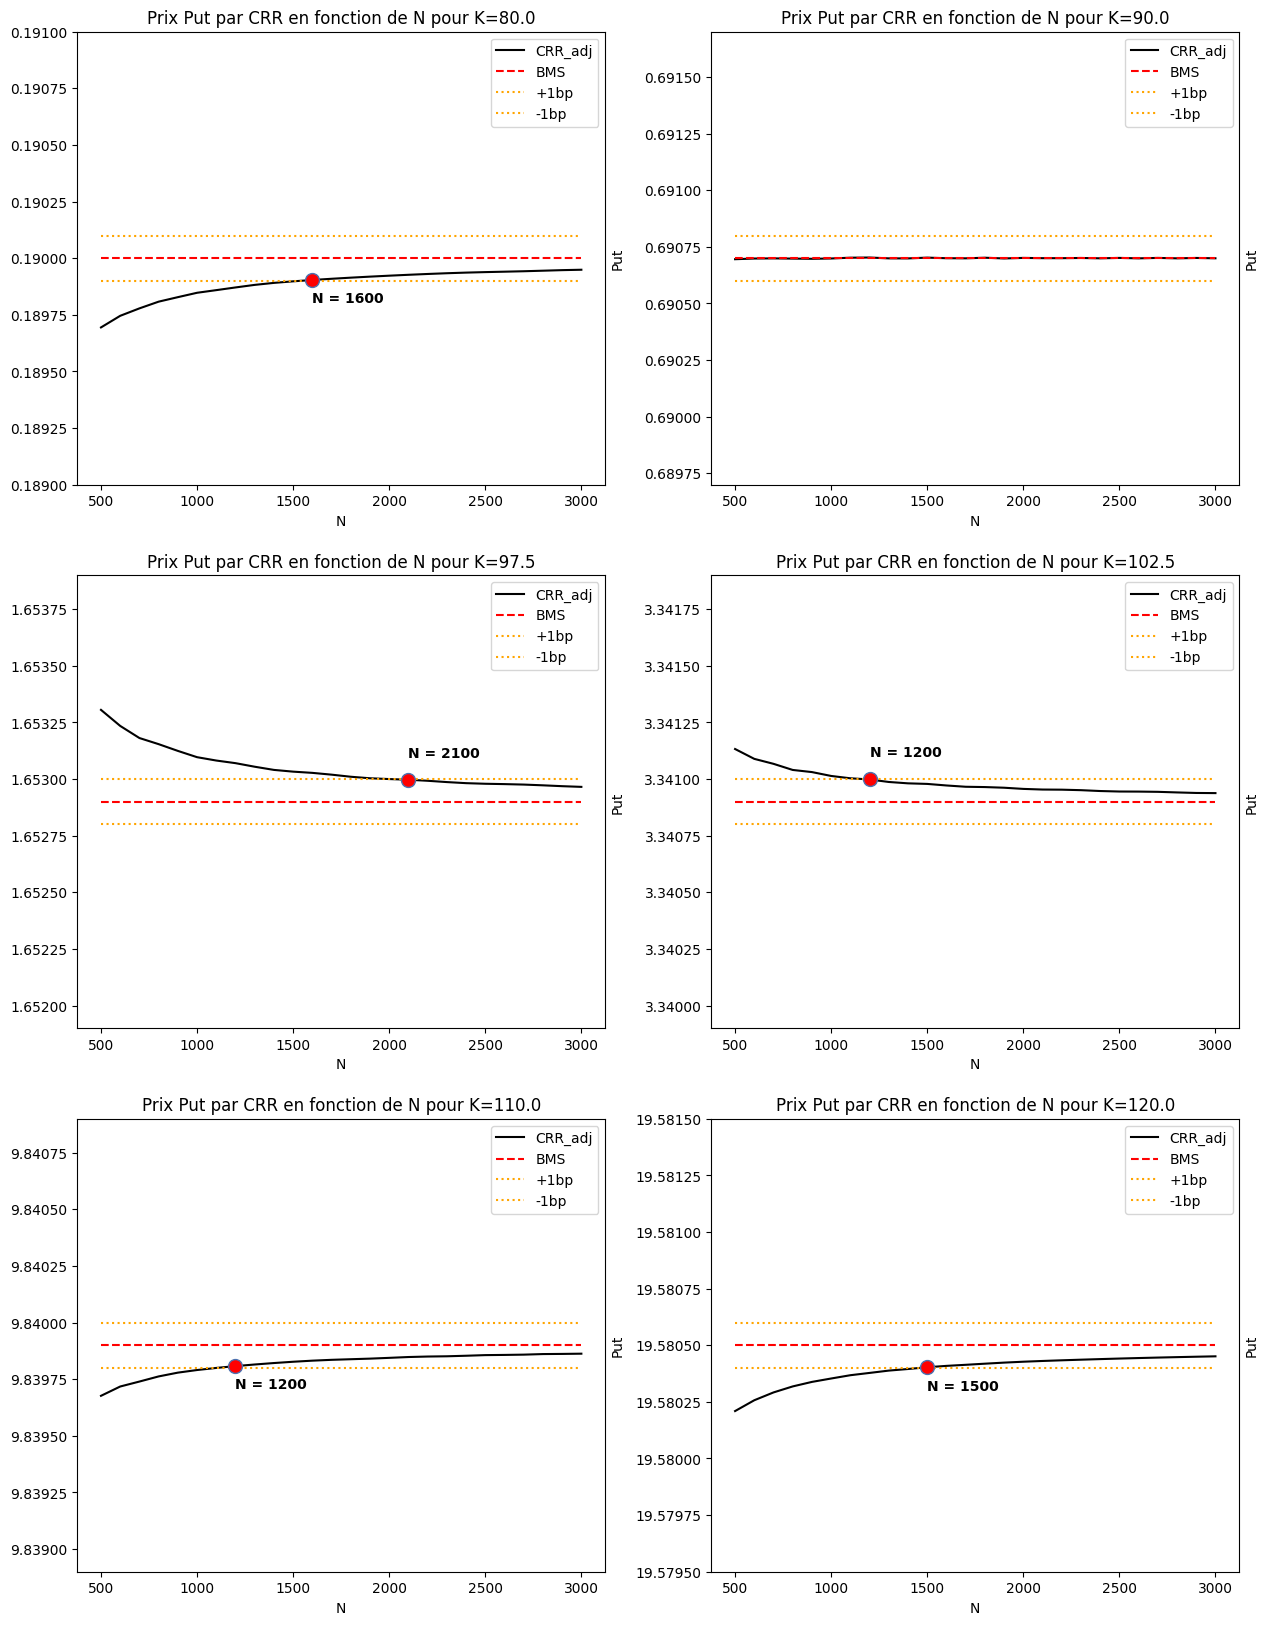

In [9]:
plot_CRR_tree(
    df_CRR_list=[[df_CRR_BD, "CRR_adj", "k"]],
    N_Range=N_Range,
    zoom_factor=10,
    cross=True,
)

En appliquant la correction de Broadie et Detemple, la convergence se fait aussi rapidement qu'avant 500 pas pour le put avec un strike à 90. C'est le put avec un strike de 97.5 qui prend le plus de temps à converger avec 2100 pas. C'est donc avec 2100 pas que tous les strikes respectent une tolérance de $\pm$ 1bp.

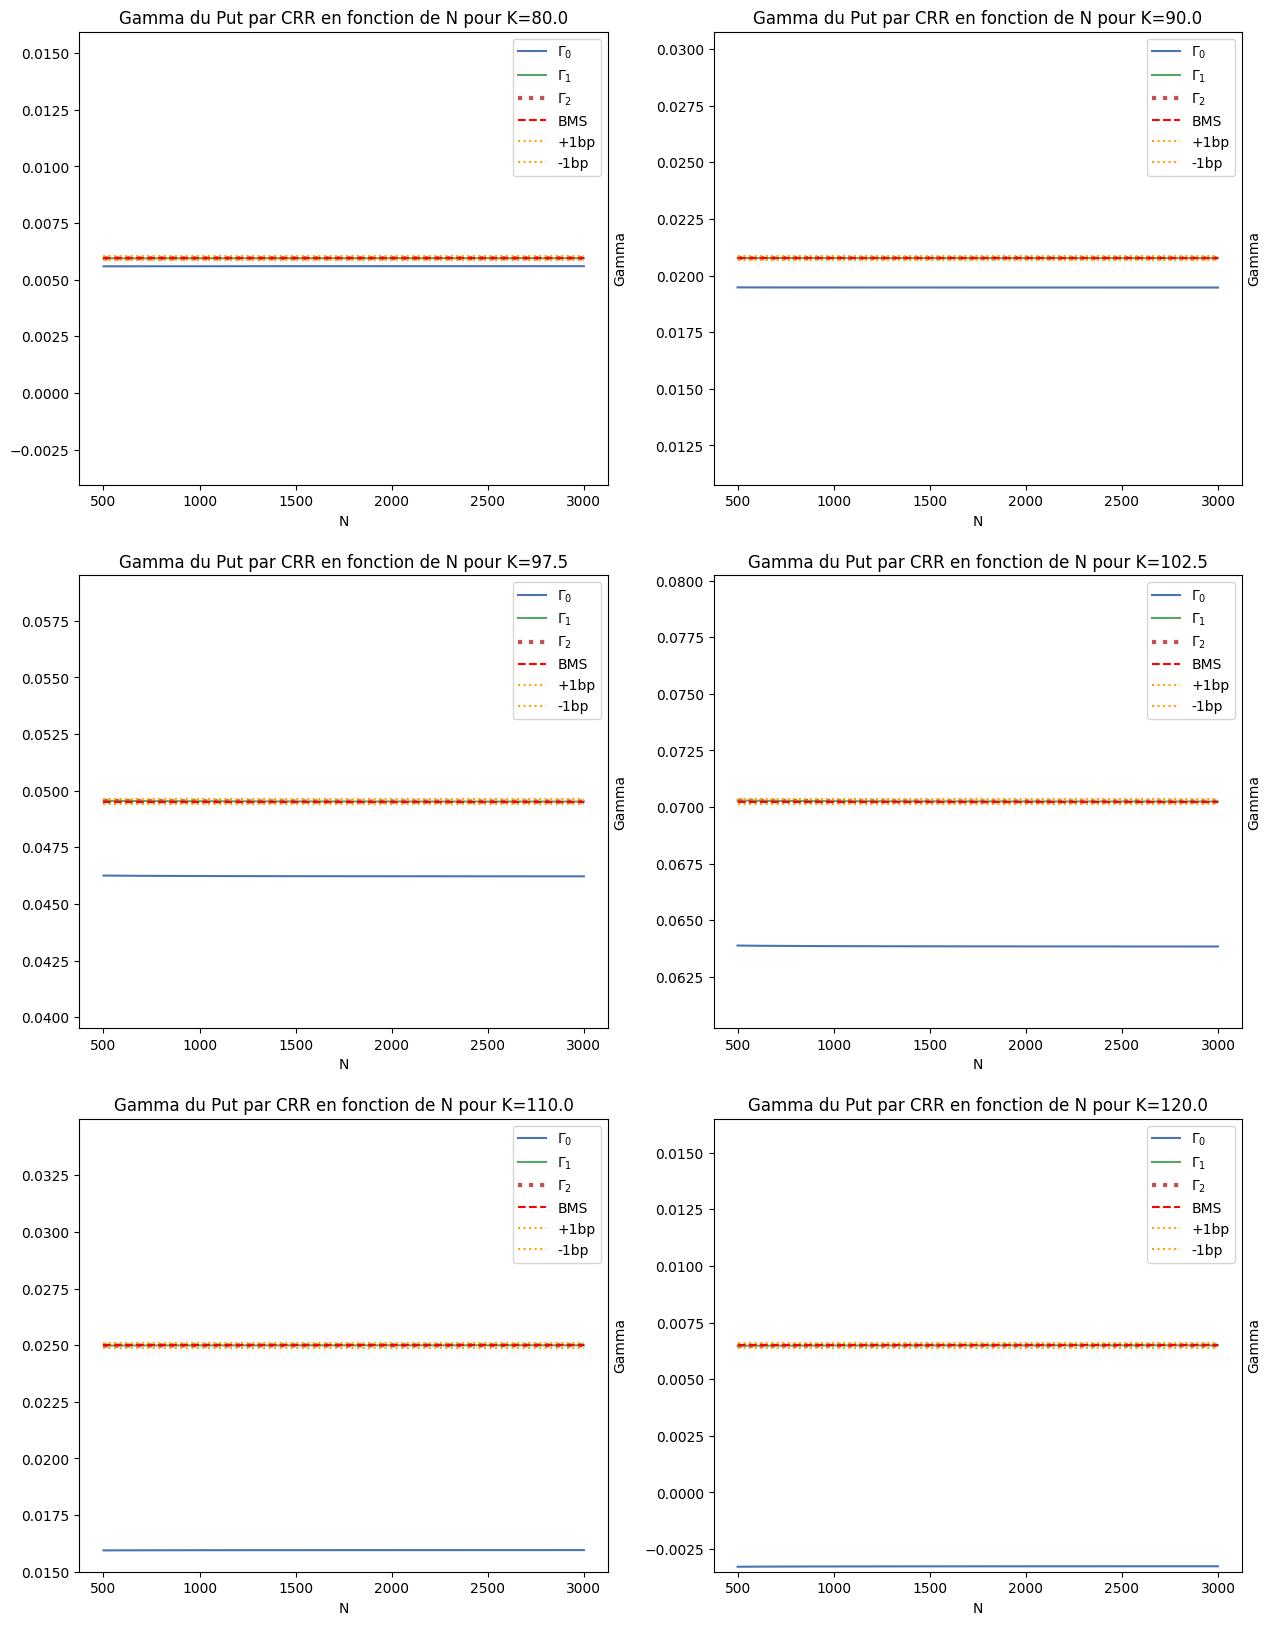

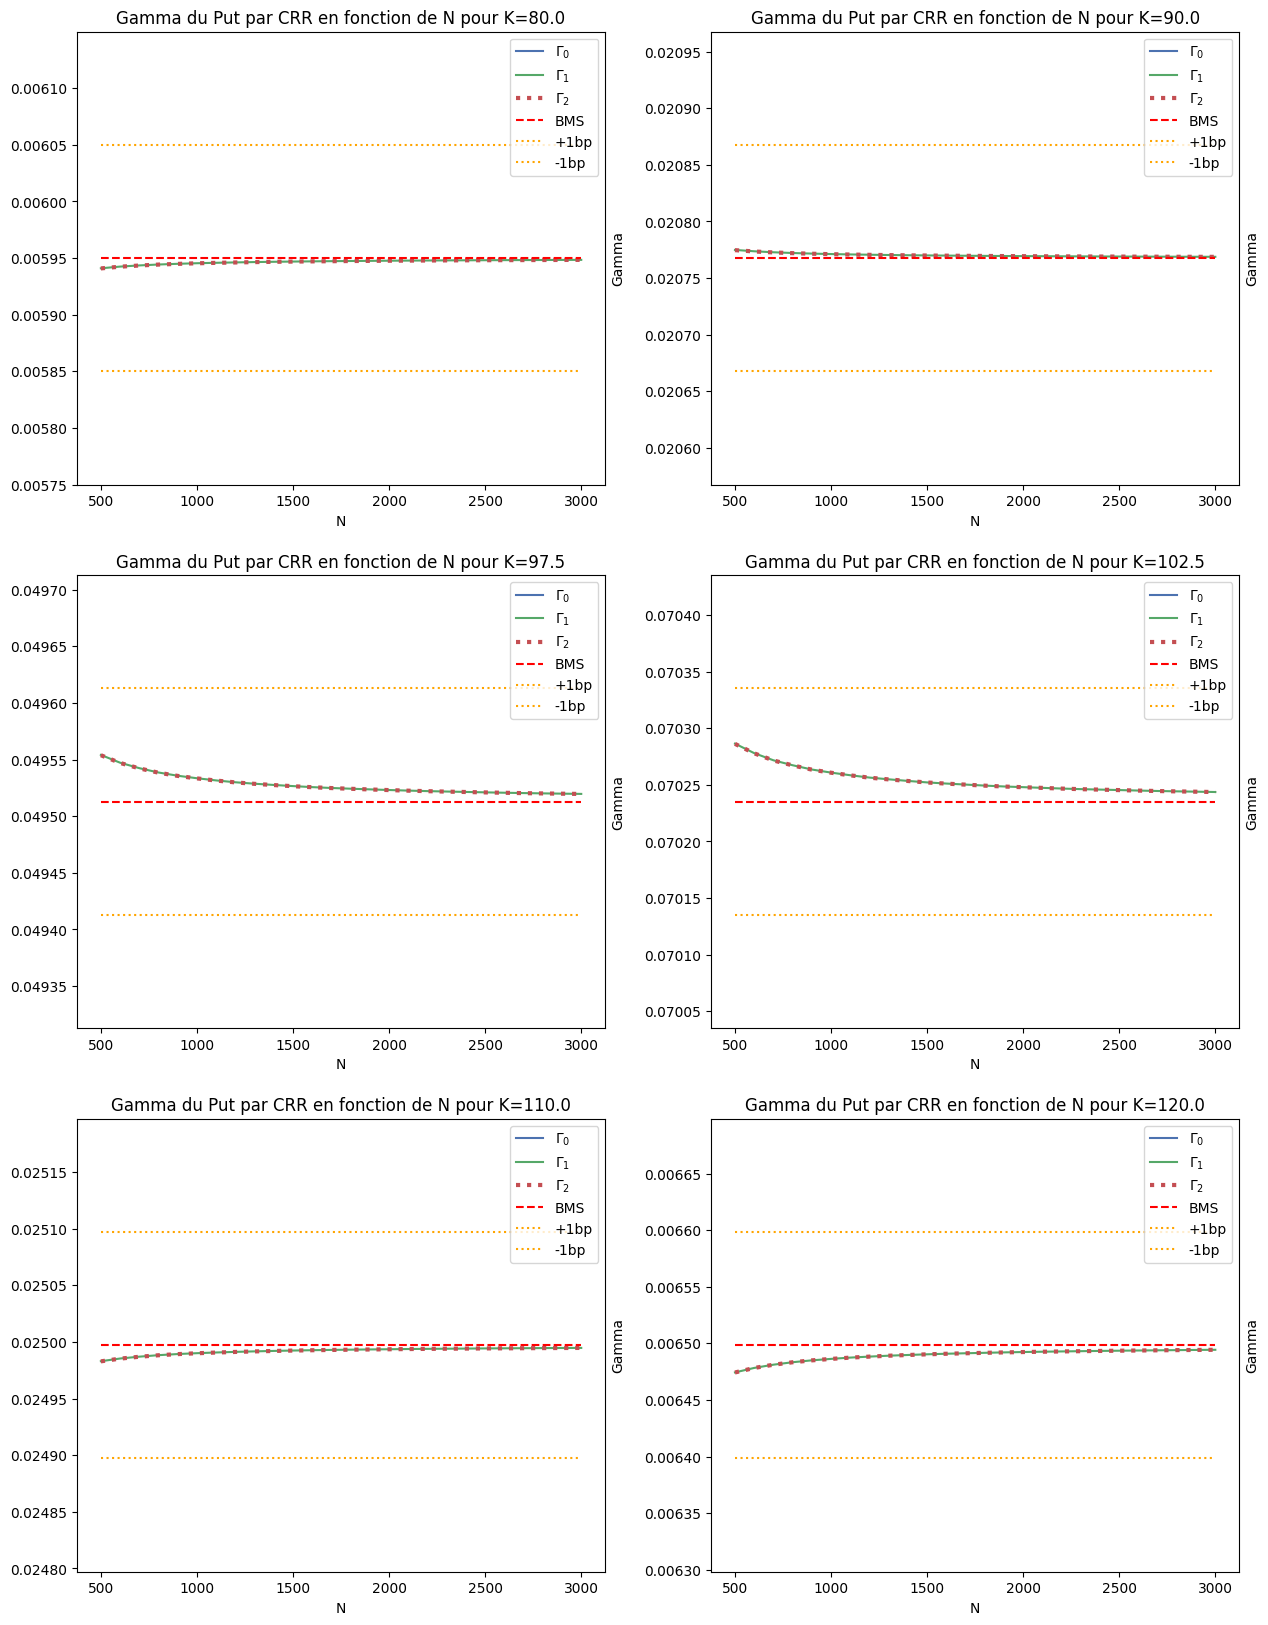

In [10]:
plot_gamma(gammas=gamma_BD, gamma_bms=gamma_bms, N_Range=N_Range, zoom_factor=100)
plot_gamma(gammas=gamma_BD, gamma_bms=gamma_bms, N_Range=N_Range, zoom_factor=2)

Premièrement, les 6 graphiques ont été générés 2 fois afin de pouvoir bien montrer le comportement des 3 approximations du gamma. Les premiers graphiques qui ont été générés montrent que l'approximation du $\Gamma$ par $\Gamma_0$ est mauvaise. En effet, elle donne un valeur toujours inférieur au $\Gamma_{BMS}$ et aux autres approximations, sans jamais entrer dans la tolérance de $\pm$ 1bp. Elle va même jusqu'à donner une valeur négative pour le strike de 120. Or, un $\Gamma$ négatif ne fait pas de sens. 

Pour ce qui est des deuxièmes graphiques générés, ils montrent une convergence de l'approximation par $\Gamma_1$ et $\Gamma_2$ vers $\Gamma_{BMS}$. Cette convergence se fait même plus rapidement que la convergence des valeurs des puts. Il est aussi intéressant de noter que $\Gamma_1$ et $\Gamma_2$ se comporte exactemement de la même façon.

Par ailleurs, il est logique que l'approximation par $\Gamma_1$ est plus précise que celle par $\Gamma_0$. Rappelons que $\Gamma_0$ s'obtient par la discrétisation de la dérivée seconde par rapport au sous-jacent. Quant à $\Gamma_1$, il s'obtient en le définissant comme la dérivée première du $\Delta$ par rapport au sous-jacent, où $\Delta$ s'obtient par la discrétisation de la dérivée première par rapport au sous-jacent. Bref, l'erreur commise par $\Gamma_0$ sera plus grande car l'erreur de discrétisation associée à une dérivée seconde est plus grande que l'erreur de discrétisation associée à une dérivée première.

# Question 5
Soit $N^*$ le nombre de pas de temps nécessaire à une convergence pour les 6 strikes (cf. Question 4). Ajoutez à la table dans l'énoncé de la Question 1 les colonnes suivantes:

`
colnames = ['IV','Amer','EarlyEx','Gamma_e','Gamma_a','Gamma_ex']
`

qui contiendront pour chaque strike, respectivement, la volatilité implicite (en Q1), la valeur de l'américaine, la prime associée à l'exercice anticipé et le gamma de l'européenne (BMS) et de l'américaine, et la différence entre les gammas.

Discutez.

In [11]:
# Nombre de pas nécessaire à la convergence (voir Q4)
N_star = 2100
N_Range = np.arange(N_star, N_star + 1)

# Calcul des valeurs des puts américains et des gammas
Amer, Gamma_a = CRR_tree_BD_df(
    S=S_0,
    K=info["Strike"],
    T=T,
    r=r_f,
    sigma=info["Implied vol."],
    Type=1,
    N_Range=N_Range,
    ret_gamma=True,
)

Euro, Gamma_e = CRR_tree_BD_df(
    S=S_0,
    K=info["Strike"],
    T=T,
    r=r_f,
    sigma=info["Implied vol."],
    Type=0,
    N_Range=N_Range,
    ret_gamma=True,
)

# Mise en forme de de la table info
info["Amer"] = list(Amer.iloc[0])
info["EarlyEx"] = info["Amer"] - info["Put"]
info["Gamma_e"] = [float(gamma_e["gamma_1"]) for gamma_e in Gamma_e]
info["Gamma_a"] = [float(gamma_a["gamma_1"]) for gamma_a in Gamma_a]
info["Gamma_ex"] = info["Gamma_a"] - info["Gamma_e"]

info = info.rename(columns={"Implied vol.": "IV"})
info

,Strike,Put,IV,Amer,EarlyEx,Gamma_e,Gamma_a,Gamma_ex
0,80.0000,0.1900,0.4512,0.1904,0.0004,0.0059,0.0060,0.0000
1,90.0000,0.6907,0.3523,0.6939,0.0032,0.0208,0.0209,0.0002
2,97.5000,1.6529,0.2534,1.6684,0.0155,0.0495,0.0504,0.0009
3,102.5000,3.3409,0.1845,3.4083,0.0674,0.0702,0.0746,0.0044
4,110.0000,9.8399,0.2356,10.0660,0.2261,0.0250,0.0296,0.0046
5,120.0000,19.5805,0.3067,20.0000,0.4195,0.0065,0.0000,-0.0065


Pour commencer, nous avons calculé la valeur du put américain à l'aide de l'arbre binomial ajusté par Broadie et Detemple avec 2100 pas de temps (nombre de pas de temps nécessaire pour une convergence à tous les strikes, voir Q4). On remarque rapidement que la prime lié à l'exercice anticipé de l'option Américaine est positive pour tous les strikes. On remarque aussi que cette prime est d'autant plus importante que l'option est dans la monnaie. Ce résultat pourrait s'expliquer par l'optionnalité d'exercice de l'américaine (valeur intrinsèque), permettant au détenteur de l'option d'exercer lorsqu'il est "in the money" ou "deep in the money".

On retrouve aussi le caractère concave du gamma pour les deux options, avec un maximum autour du put "at the money". Cela est du au fait que le delta est moins sensible à un changement dans le sous-jacent lorsqu'il est "deep in the money" ou "deep out of the money" car il y a une probabilité faible de voir un inversement de "moneyness" avant échéance. On remarque aussi que le gamma de l'option américaine est plus grand que celui de l'option européenne pour quasiment tous les strikes (excepté pour le strike à 120$).

# Question 6

L'action sous étude à, historiquement, eu une volatilité $\sigma_0 = 16\%$. Vous croyez que cette mesure est adéquate pour le mois à venir. La simulation ci-après offre donc une représentation des scénarios possible (sous les hypothèses BMS).

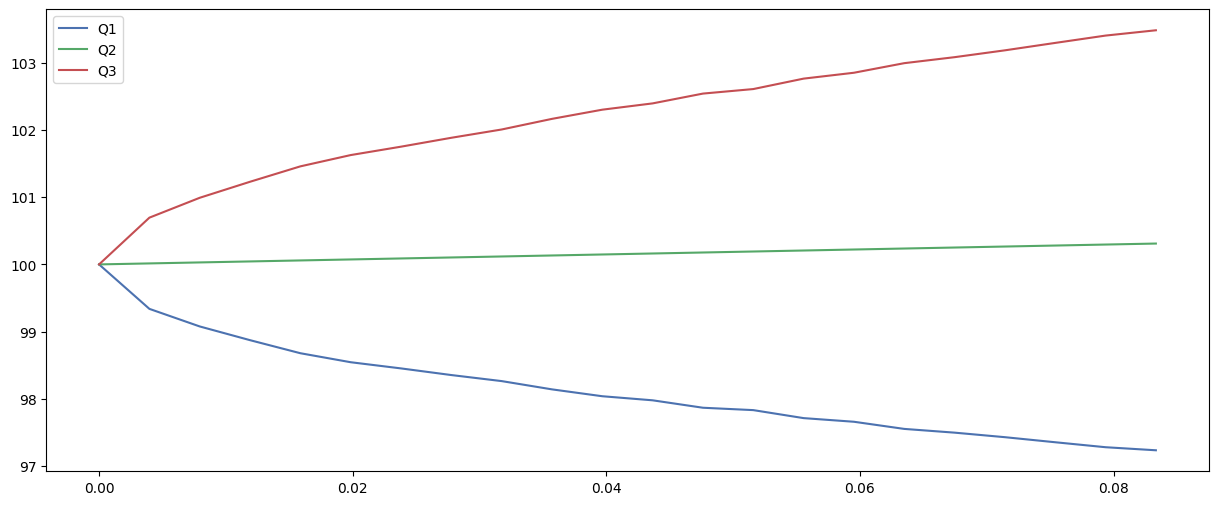

In [12]:
sigma_0 = 0.16
dt = 1 / 252  # Every day, assuming 252 business days per year
n_days = int(T / dt)
n_sim = 10000
shocks = antithetic_normal(n_days, n_sim)
S_t = simulate_underlying(S_0, r_f, 0.0, sigma_0, dt, shocks)

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
time_t = np.arange(S_t.shape[0]) * dt
stats = pd.DataFrame(S_t.T).describe()
ax.plot(time_t, stats.T["25%"], label="Q1")
ax.plot(time_t, stats.T["50%"], label="Q2")
ax.plot(time_t, stats.T["75%"], label="Q3")
ax.legend();

Si les hypothèse BMS étaient effectivement respectées, quelle serait le prix des 6 puts 
d'intérêt pour une volatilité $\sigma_0$? Quelle est la différence $p_{mkt} - p_{bms}$? Que justifie cette différence selon vous?

In [13]:
p_bms = option_price(
    S=S_0, K=info["Strike"], r=r_f, y=0, T=T, sigma=sigma_0, is_call=False
)
p_mkt = list(info["Put"])
diff = pd.DataFrame(
    np.vstack([p_mkt, p_bms, p_mkt - p_bms]).T, columns=["p_mkt", "p_bms", "Diff"]
)
diff

,p_mkt,p_bms,Diff
0,0.1900,0.0000,0.1900
1,0.6907,0.0130,0.6777
2,1.6529,0.7208,0.9321
3,3.3409,3.0793,0.2616
4,9.8399,9.5867,0.2532
5,19.5805,19.5011,0.0794


Pour chacun des 6 puts européen mentionnés précédemment, vous souhaitez utiliser les simulations ci-haut afin d'évaluer une stratégie de delta-hedging, sous l'hypothèse que vous avez vendu le put en question (négliger le multiplicateur de 100 ici). À tous moment $t = n\Delta t$, vous calculerez le delta de chaque put en utilisant la $\sigma(t,K)$ définie comme suit:
\begin{equation*}
    \sigma^2(t,K) = \sigma_0^2 + \frac{T - t}{T} (IV^2(0,K) - \sigma_0^2)
\end{equation*}
Quelle hypothèse faites-vous, implicitement? Cette hypothèse est-elle raisonnable en pratique?

Produisez une sous-figure par strike (`fig, axes = plt.subplots(3, 2, figsize=(15,20))`), chacune rapportant l'histogramme de la valeur finale de votre compte de marge pour un put donné. Assurez-vous que tous les histogramme utilisent les mêmes intervalles, e.g., 

`
edges = np.linspace(-1.25,2.25,100)
...
ax.hist(M[-1,:], edges);
`

Discutez des résultats. En particulier, pourquoi la distribution ne semble-t-elle pas avoir une moyenne nulle?

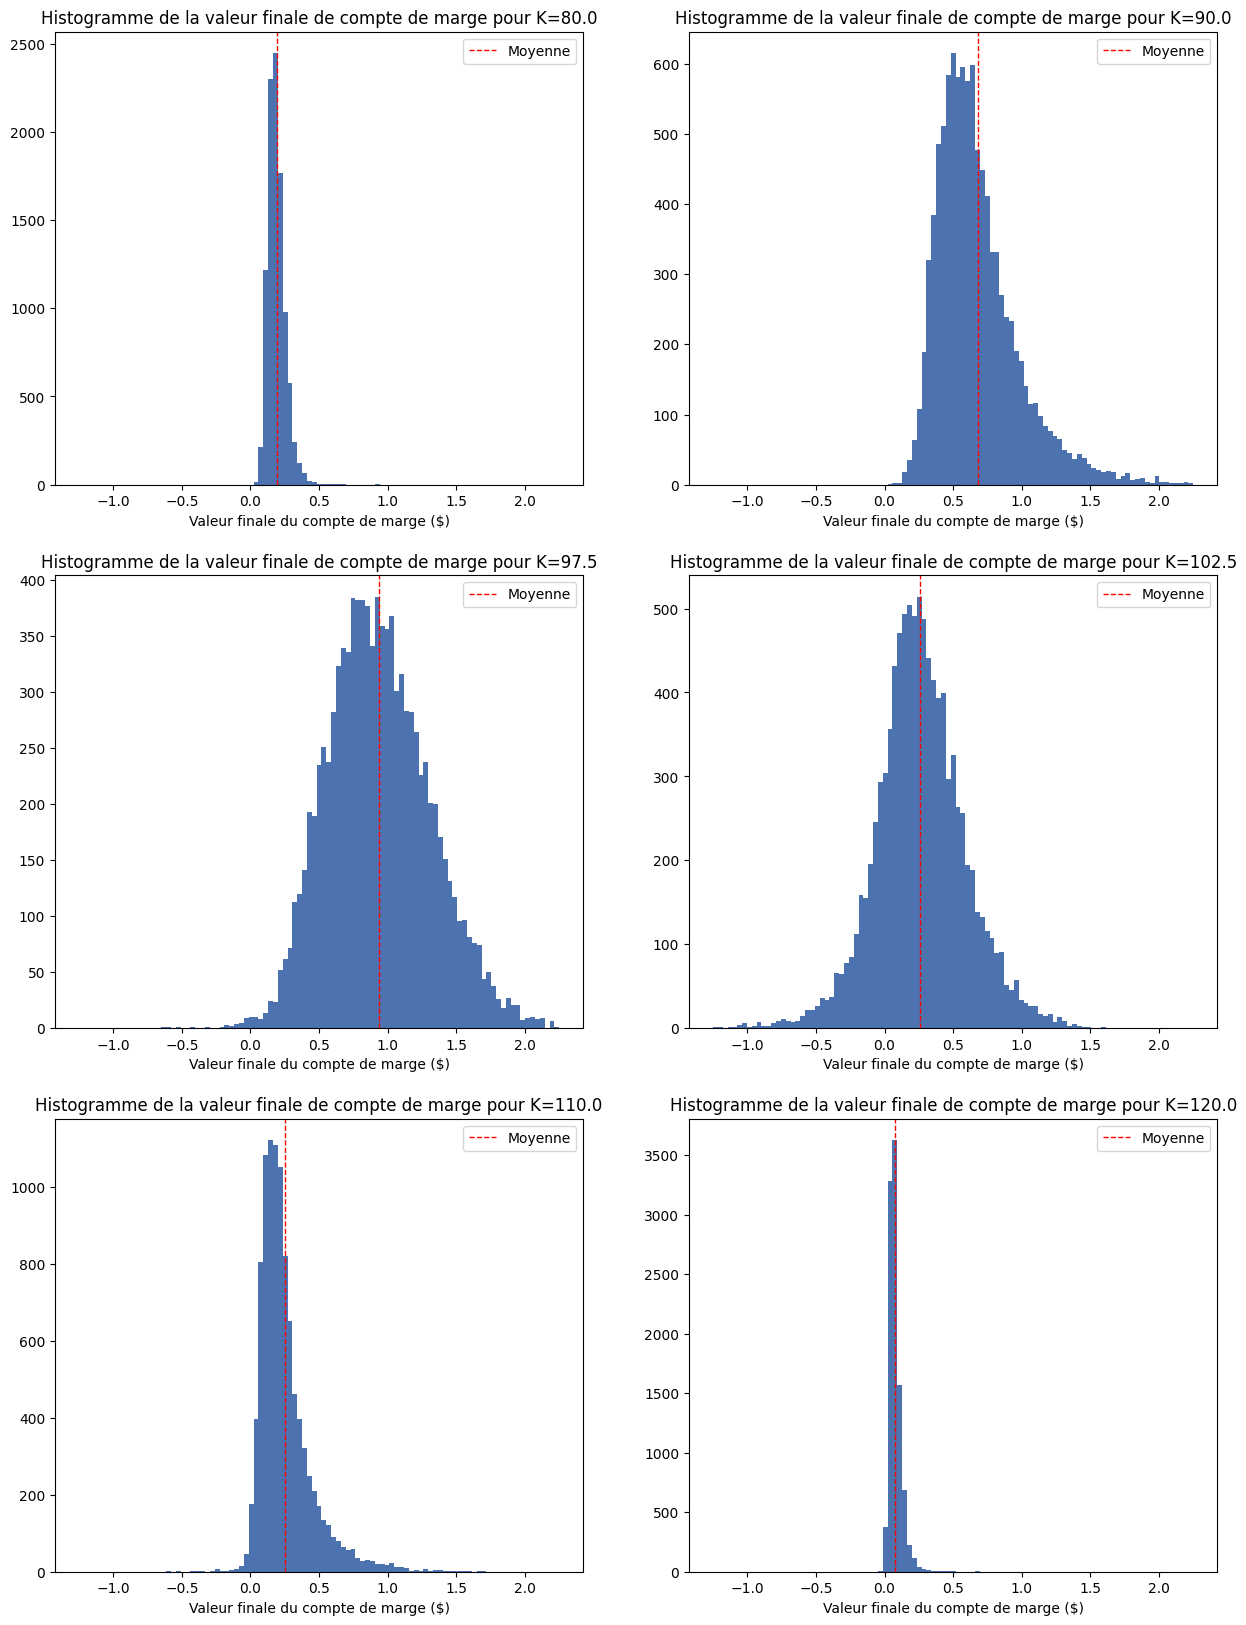

In [14]:
profit = delta_hedging(S_t=S_t, T=T, dt=dt, r=r_f, sigma_0=sigma_0, info=info)
plot_delta_hist(profit, info)

In [15]:
profit.head(20)

,0,1,2,3,4,5
0,0.3028,1.1864,0.9223,0.2339,0.1064,0.0405
1,0.2376,0.9418,1.4487,-0.1105,0.0805,0.0480
2,0.2749,1.0138,0.9409,0.1638,0.0989,0.0433
3,0.1100,0.3469,0.6754,0.3344,0.4641,0.1342
4,0.1824,0.5033,0.6336,0.2070,1.1217,0.0867
5,0.1693,0.5922,0.8497,0.3789,0.1876,0.0690
6,0.1180,0.3001,0.3048,-0.0409,0.3103,0.1178
7,0.1305,0.4393,0.7924,0.5515,0.4642,0.1228
8,0.1257,0.4750,0.8020,0.3854,0.2717,0.1095
9,0.1637,0.5876,1.1187,0.5672,0.3259,0.0871


Premièrement, l'hypothèse qu'on pose implicitement dans la formule de la volatilité utilisée pour la couverture est que la volatilité historique ($\sigma_0$) est constante durant la vie de l'option (1 mois). La validité de cette hypothèse dépend en premier lieu du choix de la série chronologique utilisée afin de calculer le $\sigma_0$ initialement. En effet, si tout les rendements depuis le début de la vie de l'actif sont utilisés dans le calcul de $\sigma_0$, l'hypothèse posée peut être valide car les volatilités sur le mois de la vie de l'option n'auront pas beaucoup de poids dans le calcul. Par contre, si la série chronologique prend seulement en compte les rendements dans la dernière année par exemple, alors la validité de l'hypothèse diminue (car les volatilités sur le mois de la vie de l'option aurait eu plus de poids donc auraient changées $\sigma_0$). Par contre, dans tout les cas, on oeut dire que l'hypothèse n'est pas valide dans le cas où on fait une étude dans laquelle on simule des prix. En effet, dans ce cas, on se retrouvera inévitablement avec des rendements plus extrêmes qui auraient affecter la volatilité historique.

Pour ce qui est des histogrammes, on peut premièrement observer que plus le gamma de l'option est grand, plus il y a de la variabilité dans la distribution de la valeur du compte de marge à l'échéance (les gammas sont les plus grands pour les put avec les prix d'exercice de 97.5 et 102.5). Ce comportement est cohérant puisque, plus le gamma est élevé, plus l'erreur commise avec une stratégie de couverture par le delta est grande. En effet, comme la courbure est plus prononcée, l'approximation de la courbe à l'aide d'une droite (e.g. delta hedging) commet une plus grande erreur. C'est aussi ce qui explique que lorsqu'on est très profondément dans ou hors de la monnaie, la valeur finale du compte de marge est très concentrée autour d'une moyenne et cette moyenne est plus près de 0. Dans ces zones le prix de l'option est a peu près linéaire, de sorte que la converture par le delta est très efficace.

 Discutez (sans les implémenter) des modifications et nuances que vous devriez apporter à votre analyse si les puts étaient américains? Donnez suffisamment de détails, en vous référant au besoin à des lignes de votre code, pour que l'on saisisse bien les difficultés et limites de l'exercice.

Premièrement, si les puts étaient américains, on ne pourrait pas simplement les évalués à chaque pas de temps de la simulation avec la formule fermée de BMS. On devrait plutôt utiliser un arbre binomial à chacune des évaluations. Cette procédure serait beaucoup plus couteuse en terme de temps de calcul. Par exemple, si on utilise un arbre avec 2000 noeuds, qu'on garde les mêmes paramètres de simulation et qu'on se assume un temps de calcul de 0.3 seconde pour un put américain sous ces contraintes (environ le temps que notre code prend), alors le temps de calcul total serait d'environ 17.5 heures pour un seul put. L'approximation est grossière, mais on voit quand même que dans le cas du put américain, le temps de calcul constitue une limitation.

Une autre difficulté dans le cas de la couverture du put américain est qu'on doit prendre en compte le fait qu'il est possible que l'option soit exercé à tout moment. C'est donc dire que si on effectue la couverture à chaque fin de journée et que le détenteur de l'option décide d'exercer juste avant la fin de la journée, on ne sera pas couvert pour la variation du sous-jacent dans la journée. Cela peut être un problème majeur, surtout si le prix du sous-jacent a varié de façon importante. Une solution à ce problème pourrait être d'augmenter la fréquence de couverture. Or, si on prend en compte les frais de transactions, cette option peut devenir coûteuse.

In [16]:
toc()

Elapsed time: 37.590017 seconds.

